#  Long Short-Term Memory for Predicting Energy Demand in Saudi Arabia 

This project comes as part of my endeavour in learning the implementation of RNNs, especially with time series forecasting. In this work I have collected the data of the following economic and demographic indicators for Saudi Arabia:
 - Energy Consumption, GDP, Electricity Generation, Population, Oil Production, Gas Production.

I'm going to treat 'Energy Consumption' as a multivariate label with respect to the rest of the variables. To predict the future output of a multivariate time series, the input variables must first be projected into the future then be used to forecast the output label.

The data set consists of 40 points on the range [1980,2019]. It's a relativley small set, nonetheless, it provides a suitable example for implemnting LSTMs in time series forecasting. 

This project is divided into to main parts:

    (1).   In this part I will make univariate LSTM models for each of the aforementioned variables, except Energy Consumption because it is the output label to my problem. I will forecast a 12 point time period for each variable. The first 8 points of this period lie at the end of the available data set. These 8 points will provide assurance that the model I will develop later (for energy consumption) is actually reliable once I perform evaluation. The last 4 points of the forcasted 12 point period will be used as input for the multivariate LSTM to predict future values for Energy Consumption.

    (2).   In this part I will develop a multivariate time series for Energy Consumption using the other variables. My method for evaluating this model is twofold. First, train/validate/test using the availble 32 data points plus 8 forecasted points from the previous section. Second, use the developed model to predict the last 8 points of the data set and evaluate. The second step is necessary to avoid cumulative error. Finally, I will use the evaluated model to forecast Energy Consumption for the future.
    
Finally, it should be noted that the results serve an educational purpose and only represent a data driven prediction which lack the influence of many factors such as political factors.

Sources:
 - for energy related variables: https://www.eia.gov/international/data/country/SAU
 - for socio-economic variables: https://www.worldbank.org/


In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
   
%matplotlib inline

In [17]:
# 'preprocess' takes in data matrix or vector and performs random shuffling + scaling + preparing input shape for the LSTM 
def preprocess(data,n_past,n_future):
    # set indecies for train/val/test split
    np.random.seed(34)
    rand_index = np.random.permutation(range(data.shape[0]-n_past))
    train_test_split_index = int(0.8 *(data.shape[0]-n_past))
    train_val_split_index = int(0.8*train_test_split_index)

    train_indecies = rand_index[:train_val_split_index]
    val_indecies = rand_index[train_val_split_index:train_test_split_index]
    test_indecies  = rand_index[train_test_split_index:]

    SC = StandardScaler()
    SC = SC.fit(data[train_indecies])
    SC_y = StandardScaler()
    SC_y = SC_y.fit(data[train_indecies,0:1])
    
    scaled_x = SC.transform(data)
    scales = {'SC':SC,'SC_y':SC_y}
    
    # prepare input for LSTM
    x_data = np.zeros((scaled_x.shape[0]-n_past, n_past, scaled_x.shape[1]))
    y_data = np.zeros((scaled_x.shape[0]-n_past, 1))
        # set input shape for LSTM
    j=n_past
    for i in range(x_data.shape[0]):
        x_data[i] = scaled_x[j-n_past:j]
        y_data[i] = scaled_x[j+n_future-1: j+n_future,0]
        j+=1
    # perform train/val/test split using generated indecies  
    x_train = x_data[train_indecies]
    x_val = x_data[val_indecies]
    x_test = x_data[test_indecies]

    y_train = y_data[train_indecies]
    y_val = y_data[val_indecies]
    y_test = y_data[test_indecies]
    
    return x_train, x_val, x_test, y_train, y_val, y_test, scales, rand_index

# 'compile_LSTM' takes in the shape of input + number of hidden layers and returns the compiled LSTM
# I should note that I set the number of units to be 10 for the univariate time series and 14 for the 
# multivariate time series due to the small number of features and data points.
def compile_LSTM(shape, units, summary=False):
    tf.random.set_seed(34)
    model = keras.Sequential(
        [
            layers.LSTM(units = units , input_shape=(shape), 
                   activation = 'relu', return_sequences=True),
            layers.LSTM(units = int(units), activation = 'relu', return_sequences=False),
            layers.Dense(units=1)
        ]
    )
    model.compile(optimizer = 'adam' , loss='mse', metrics=tf.keras.metrics.RootMeanSquaredError())
    if summary:
        model.summary()
    return model

# 'train_LSTM' takes in train/val/test and the number of units, returns: the developed model + model history + test results
def train_LSTM(x_train, x_val, x_test, y_train, y_val, y_test, units):
    
    model = compile_LSTM(shape = x_train.shape[1:], units = units, summary=False)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', 
                                           min_delta=1e-7, patience=10, restore_best_weights=True)
    history = model.fit(x_train,y_train, validation_data=(x_val, y_val),shuffle = False, epochs = 100,
                    callbacks = [es], verbose=0,batch_size = 2)
    # Test results 
    y_pred = model.predict(x_test)
    test_res = {'RMSE':mse(y_test,y_pred,squared=False), 'MAE':mae(y_test,y_pred), 'MAPE':mape(y_test,y_pred)}
    
    return model , history, test_res

# 'retrieve_time_sequence' takes in the shuffled data sets and returns the original full set with the correct time order
def retrieve_time_sequence(x_train, x_val, x_test, y_train, y_val, y_test, rand_index):
        # reconstruct
    x_data = np.concatenate((x_train,x_val,x_test),axis=0)
    y_data = np.concatenate((y_train,y_val,y_test),axis=0)

    # sort them back in the correct time order
    revert_index = revert_permutation(rand_index)
    x_data = x_data[revert_index]
    y_data = y_data[revert_index]
    
    return x_data, y_data

# predict_univariate takes in the time ordered data set + the last 4 instances corresponding to n_past + the start 
# and end indecies for forecasting, returns the forecasted values.  
def predict_univariate(x_data, last_instances, n_past, start, end):
    
    past_x = x_data[start:]
    past_y = model.predict(past_x)
    
    future_x = np.zeros((end + 1 - (x_data.shape[0] + n_past), n_past, 1))
    future_y = np.zeros((end + 1 - (x_data.shape[0] + n_past), 1))
    
    future_x[0] = last_instances
    future_y[0] = model.predict(future_x[0:1])
    for i in range(future_y.shape[0]-1):
        future_x[i+1] = np.concatenate((future_x[i,1:,:].flatten(),future_y[i].flatten()),axis=0).reshape(1,n_past,1)
        future_y[i+1] = model.predict(future_x[i+1:i+2])
        
    
    return np.concatenate((past_y,future_y),axis=0)

# 'learning_summary' plot function to produce the learning summary and the test results
def learning_summary(history, test_res):

    print("results on the test set:")
    print("RMSE = "+format(test_res['RMSE'],".4f"))
    print("MAE = "+format(test_res['MAE'],".4f"))
    print("%MAE = "+format(test_res['MAPE'],".4f"))
    fig, ax = plt.subplots(figsize=(16,6))
    ax.set_title('Train/Val Summary')
    ax.set_ylabel('Loss',fontsize=14)
    ax.set_xlabel('Epochs',fontsize=14)
    ax.plot(history.history['loss'], label = 'Training loss')
    ax.plot(history.history['val_loss'], label = 'Validation loss')
    plt.legend()
    plt.show()

# 'forecast_past' plot function to produce the results on the forecasted past instances, if this result is good 
# it will give us confidence in our multivariate model.
def forecast_past(y_true, y_pred, dates):
    
    print("Results on forecast:")
    print("RMSE = "+format(mse(y_true, y_pred, squared=False),".4f"))
    print("MAE = "+format(mae(y_true, y_pred),".4f"))
    print("MAPE = "+format(mape(y_true, y_pred),".4f"))
    fig, ax = plt.subplots(figsize=(16,6))
    ax.set_title('Prediction with multivariate model using forecasted features from univariate models')
    ax.set_ylabel('Energy Consumption (quad Btu)',fontsize=14)
    ax.set_xlabel('Year',fontsize=14)
    ax.bar(dates, y_true.flatten(), label = 'Original values', color='k', width = 0.3)
    ax.bar(dates, y_pred.flatten(), label = 'Predicted values', color='gray', width = 0.2)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.f'))
    plt.legend() 
    plt.show()

# 'forecast_energy_consumption' plot function to produce the final result of the project. 
def forecast_energy_consumption(y_past,y_forecasted,dates):
    
    fig, ax = plt.subplots(figsize=(16,6))
    ax.set_title('Prediction with multivariate model for past and future')
    ax.set_ylabel('Energy Consumption (quad Btu)',fontsize=14)
    ax.set_xlabel('Year',fontsize=14)
    ax.bar(dates, y_past.flatten(), label = 'Original values', color='k', width = 0.5)
    ax.bar(np.arange(2012,2025), y_forecasted.flatten(), label = 'Predicted values', color='gray', width = 0.3)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.f'))
    plt.legend() 
    plt.show()

    # 'revert_permutation' takes in a random permutation index and returns the inverse, 
# this is used to retriev the time sequence after shuffling
def revert_permutation(p):
    p = np.asanyarray(p) 
    s = np.empty_like(p)
    s[p] = np.arange(p.size)
    return s

In [27]:
df = pd.read_csv('./data.csv')

display(df.head())
df.shape

,Energy Consumption,GDP,Electricity Generation,Population,Oil Production,Gas Production,Year
0,1.653827,1.645420e+11,20.452,9691471,9900.158470,334,1980
1,2.018999,1.842920e+11,26.950,10311771,9814.947945,564,1981
2,1.985304,1.532390e+11,32.912,10988851,6482.991781,430,1982
3,2.121986,1.291720e+11,35.190,11701132,5085.895890,418,1983
4,2.466369,1.196250e+11,40.069,12418836,4663.202186,620,1984


(40, 7)

# 1. Univariate Time Series Forecasting for Variables

In this part I will train a univariate time series for each variable and then:

- Forecast the last 8 points in the original time series + future 5 points that represent the values for a variable in the years [2012-2019] + [2020-2024]. 
- Evaluate the performance of the five univariate models

# 1.1
Forecast the last 8 points in the original time series + future 5 points that represent the values for a variable in the years [2012-2019] + [2020-2024].


In [19]:
columns = list(df)[:-1] # excluding 'Year'

data = df[columns].astype(float)

# create dictionaries to save the results for each variable
data_dict = {}
scales_dict  = {}
model_dict = {}
history_dict = {}
test_res_dict = {}
y_pred_dict = {}

summary = 1
for var in columns[1:]:
    
    var_data = data[[var]].values
    n_future = 1 # number of time-step into the future to be predicted.
    n_past = 4 # number of past instances to consider for every predicted instance. 
    
    # preprocess and record the random shuffling index, the random index will be needed to retrieve the time sequence
    x_train, x_val, x_test, y_train, y_val, y_test, scales, rand_index = preprocess(var_data,n_past = n_past,
                                                                                    n_future = n_future)
      #save
    var_dict = {'x_train':x_train, 'x_val':x_val, 'x_test':x_test,
               'y_train':y_train, 'y_val':y_val, 'y_test':y_test} 
    data_dict[var] = var_dict 
    scales_dict[var] = scales
    
    # create univariate model and keep results
    model , history, test_res = train_LSTM(x_train, x_val, x_test, y_train, y_val, y_test, units= 10)
        #save
    model_dict[var] = model
    history_dict[var] = history
    test_res_dict[var] = test_res
    
    # retrieve the time sequence of the data using the saved random index
    x_data, y_data = retrieve_time_sequence( x_train, x_val, x_test, y_train, y_val, y_test, rand_index)
    
    # Forecast the last 8 years [2012,2019] and the future 5 years [2020,2024]
        # since we have the first 4 points not included then the start index is: 
        # (the size of the data set - n_past - last 8 years = 40 - 4 - 8 = 28
        # the end index can be treated as (the size of the past set + the size of the future set - 1) = 40 +5 -1 = 44
    last_instances = scales['SC'].transform(var_data[-n_past:])
    y_pred = predict_univariate(x_data, last_instances = last_instances, n_past = n_past, start = 28, end = 44)
        #save
    y_pred_dict[var] = y_pred
    
    if summary:
        model.summary()
        print('Shape of x_train = {}, y_train = {}'.format(x_train.shape, y_train.shape))
        print('Shape of x_val = {}, y_val = {}'.format(x_val.shape, y_val.shape))
        print('Shape of x_test = {}, y_test = {}'.format(x_test.shape, y_test.shape))
        summary=0

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 4, 10)             480       
                                                                 
 lstm_13 (LSTM)              (None, 10)                840       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
Shape of x_train = (22, 4, 1), y_train = (22, 1)
Shape of x_val = (6, 4, 1), y_val = (6, 1)
Shape of x_test = (8, 4, 1), y_test = (8, 1)


# 1.2
Evaluate the performance of the five univariate models

In [20]:
RMSE_sum = 0
MAE_sum = 0
MAPE_sum = 0

for var in test_res_dict:
    RMSE_sum += test_res_dict[var]['RMSE']
    MAE_sum +=test_res_dict[var]['MAE']
    MAPE_sum +=test_res_dict[var]['MAPE']
print('The averaged performance of the 5 univariate LSTM models:')
print('avg_RMSE = ' + format(RMSE_sum/len(test_res_dict),".4f"))
print('avg_MAE = ' + format(MAE_sum/len(test_res_dict),".4f"))
print('avg_MAPE = ' + format(MAPE_sum/len(test_res_dict),".4f"))

The averaged performance of the 5 univariate LSTM models:
avg_RMSE = 0.1281
avg_MAE = 0.0909
avg_MAPE = 0.4223


# 2. Multivariate Time Series for Energy Consumption
In this section I will use the original data on the period [1980-2011] and the forecasted values for the variables on the period [2012-2024] to build a multivariate time series for energy consumption 'ENcons'.

- construct the time series dataframe:
    - inverse transform the predicted values.
    - put the transformed predicted values in place of the original values in the set 'data'.
- perform the training & evaluation of the multivariate LSTM model.
- forecast the last 8 time steps [2012,2019] of the data set & evaluate.
- forecast future years.

# 2.1
   - inverse transform the predicted values.
   - put the transformed predicted values in place of the original values in the set 'data'.

In [21]:
replace_index = len(y_pred_dict['GDP'])-5 #the number of instances that will be replaced by their forecasted values.
data = data.values
for i, var in enumerate(columns[1:]):
    # inverse transform the predicted values
    y_pred_dict[var] = scales_dict[var]['SC'].inverse_transform(y_pred_dict[var])
    
    # replace original values in the data set with the predicted values 
    data[-replace_index:,i+1:i+2] = y_pred_dict[var][:replace_index]  

# 2.2
Perform the training & evaluation of the multivariate LSTM model
 

In [22]:
# perform Preprocessing
x_train, x_val, x_test, y_train, y_val, y_test, scales, rand_index = preprocess(data,n_past = 4, n_future = 1)
print('Shape of x_train = {}, y_train = {}'.format(x_train.shape, y_train.shape))
print('Shape of x_val = {}, y_val = {}'.format(x_val.shape, y_val.shape))
print('Shape of x_test = {}, y_test = {}'.format(x_test.shape, y_test.shape))

Shape of x_train = (22, 4, 6), y_train = (22, 1)
Shape of x_val = (6, 4, 6), y_val = (6, 1)
Shape of x_test = (8, 4, 6), y_test = (8, 1)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 4, 14)             1176      
                                                                 
 lstm_23 (LSTM)              (None, 14)                1624      
                                                                 
 dense_11 (Dense)            (None, 1)                 15        
                                                                 
Total params: 2,815
Trainable params: 2,815
Non-trainable params: 0
_________________________________________________________________
results on the test set:
RMSE = 0.0952
MAE = 0.0719
%MAE = 0.1167


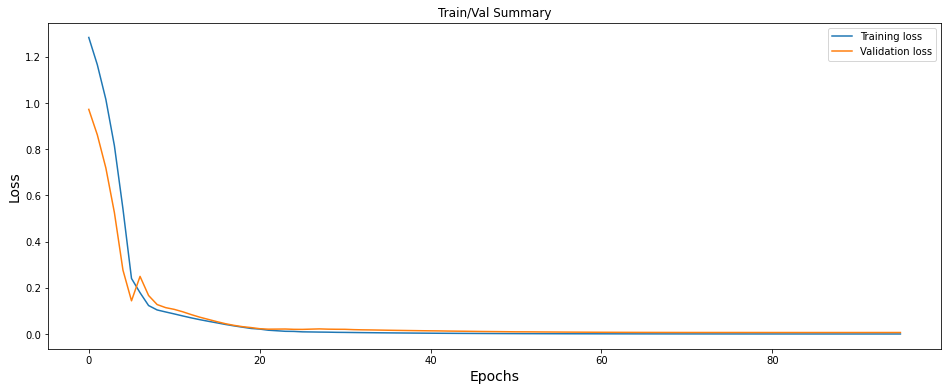

In [23]:
# create Multivariate model and keep results
model, history, test_res = train_LSTM(x_train, x_val, x_test, y_train, y_val, y_test,units=14)
model.summary()
learning_summary(history, test_res)

# 2.3
Forecast the last 8 time steps [2012,2019] of the data set & evaluate.


Results on forecast:
RMSE = 0.2084
MAE = 0.1319
MAPE = 0.0125


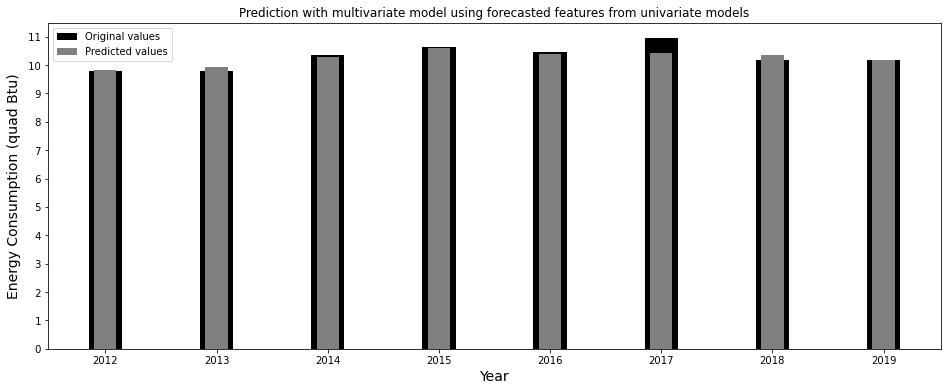

In [24]:
# retrieve time sequence 
x_data, y_data = retrieve_time_sequence( x_train, x_val, x_test, y_train, y_val, y_test, rand_index)

# prepare for plot
dates = df['Year'].values.flatten()
y_true = data[-replace_index:,0:1]
y_pred = scales['SC_y'].inverse_transform(model.predict(x_data[-replace_index:]))
forecast_past(y_true, y_pred, dates[-replace_index:])

These results give confidence in the multivariate model since it's fitting the past 8 years with relativley good precision

# 2.4
Forecast future years.

In [25]:
# get the forecaste values of the 5 variables
future_data = y_pred_dict['GDP'][replace_index:]
for var in list(y_pred_dict)[1:]:
    future_data = np.concatenate((future_data, y_pred_dict[var][replace_index:]),axis=1)
# append zeros column to save place for the values of y (energy condumption) to be forecasted
future_data = np.concatenate((np.zeros((5,1)),future_data),axis=1) 

# concatenate with the last 4 instances from the original data(this is needed because the future predicted value depends on them)
future_data = np.concatenate((data[-4:],future_data),axis=0)
scaled_future_data = scales['SC'].transform(future_data)

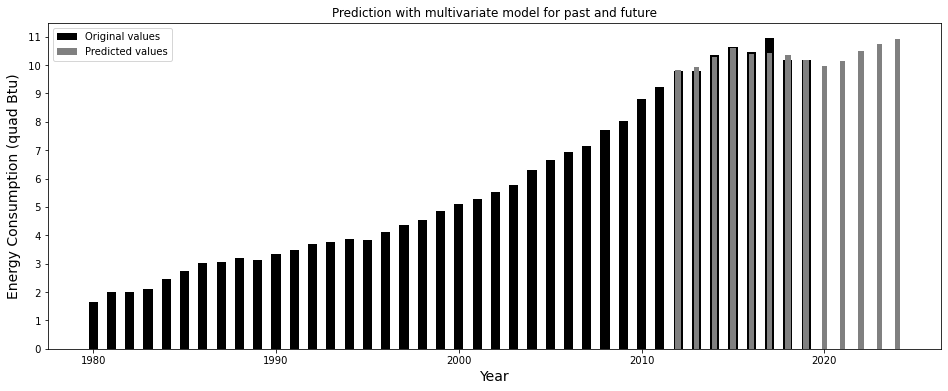

In [26]:
# prepare input for LSTM
x_future = np.zeros((5,4,6))
y_future = np.zeros((5,1))

j=n_past # = 4
for i in range(x_future.shape[0]):
    # prepare input instances
    x_future[i] = scaled_future_data[j-n_past:j,:]
    # predict
    y_future_pred = model.predict(x_future[i:i+1]).flatten()
    scaled_future_data[j,0]= y_future_pred # replace the zero value in the first column with the true y value
    y_future[i] = y_future_pred
    j+=1

# plot the real values vs. predicted values
y_past = data[:,0:1]
y_forecasted = np.concatenate((y_pred,scales['SC_y'].inverse_transform(y_future)),axis=0)
forecast_energy_consumption(y_past,y_forecasted,dates)